In [1]:
import gym
import gym_toytext
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# The Environment
env = gym.make('Roulette-v0')

## Plotting Utils

In [3]:
def plot_training_returns(rets, title="Returns vs. Episodes", N=10):
    X = [i+1 for i in range(len(rets))]
    plt.plot(X, rets)
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel(f" Average returns over N={N} rounds")
    plt.show()

# Monte Carlo Agent Class

In [4]:
class MonteCarloAgent():
    '''
    Class for agents which can be trained using on-policy and off-policy Monte Carlo methods
    '''

    def __init__(self, env, gamma=0.9, epsilon=0.1):
        self.env = env

        # Agent parameters
        self.gamma = gamma
        self.epsilon_base = epsilon
        self.epsilon = epsilon

        # Action space
        self.actions = [a for a in range(38)]

        # State-action value function
        self.Q = [0.0 for action in self.actions]

        # Main policy in on-policy learning and target policy for off-policy learning
        self.PI = [1/len(self.actions) for action in self.actions]

        # Behaviour policy for off-policy learning
        self.MU = [1/len(self.actions) for action in self.actions]

        # Parameters for off-policy learning
        self.C = [0.0 for action in self.actions]
        self.returns = [[] for action in self.actions]

    # Prints the state-action values self.Q
    def printValues(self):
        for action in self.actions:
            print(self.Q[action], end=" ")
        print()

    # Prints out the policy
    def printPolicy(self):
        for action in self.actions:
            print(self.PI[action], end=" ")
        print()

    # Reset the Q table and other parameters before training
    def reset(self, method="on_policy"):
        self.epsilon = self.epsilon_base
        self.Q = [0.0 for action in self.actions]
        self.C = [0.0 for action in self.actions]
        self.returns = [[] for action in self.actions]
        
        # Main policy in on-policy learning and target policy for off-policy learning
        if method == "on_policy":
            self.PI = [1/len(self.actions) for action in self.actions]
        elif method == "off_policy":
            self.PI = [0.0 for action in self.actions]
            self.PI[np.argmax(self.Q)] = 1.0
        
        # Behaviour policy for off-policy learning
        self.MU = [1/len(self.actions) for action in self.actions]
        

    # Sample an action according to the distribution give by the current policy self.PI
    def sample_action(self, policy=None):
        policy = self.PI if policy is None else policy
        return np.random.choice(self.actions, p=policy)

    # Generate an episode while following the current policy
    def run(self, policy=None):
        policy = self.PI if policy is None else policy
        actions = []
        rewards = []
        ret = 0
        done = False
        self.env.reset()
        while not done:
            action = self.sample_action(policy)
            observation, reward, done, info = env.step(action)
            ret = self.gamma*ret + reward
            actions.append(action)
            rewards.append(reward)
        return actions, rewards, ret

    # Returns action with the greatest Q value. In case of tie, action is chosen
    # randomly from available actions
    def greedy_action(self):
        max_action_value = np.max(self.Q)
        optimal_actions = [action for action in self.actions if self.Q[action] == max_action_value]
        return np.random.choice(optimal_actions)

    # Sample one episode and make an on-policy update using first visit Monte-Carlo.
    def update_on_policy(self):
        actions, rewards, ret = self.run()
        first_occurence = [len(actions) for action in self.actions]
        
        # Store first occurrence of every action in the episdode
        for t in range(len(actions) - 1, -1, -1):
            first_occurence[actions[t]] = t
        
        ret = 0
        for t in range(len(actions) - 1, -1, -1):
            action = actions[t]
            reward = rewards[t]
            ret = self.gamma*ret + reward
            if first_occurence[action] < t:
                continue
            self.returns[action].append(ret)
            self.Q[action] = np.mean(self.returns[action])
            action_greedy = np.argmax(self.Q)
            for a in self.actions:
                self.PI[a] = self.epsilon / len(self.actions)
            self.PI[action_greedy] += 1 - self.epsilon

    # Run first vist Monte-Carlo for training an on policy agent
    # Returns the returns obtained after every iteration of training
    def train_on_policy(self, num_iterations=10000, num_runs=5):
        self.reset()
        rets = []
        for iteration in range(1, num_iterations+1):
            self.update_on_policy()
            runs = [self.run()[2] for _ in range(num_runs)]
            rets.append(np.mean(runs))
            self.epsilon = 0.9 / iteration
        return rets

    # Sample one episode using the behaviour policy self.MU and update the target policy self.PI
    # using every visit Monte Carlo
    def update_off_policy(self):
        actions, rewards, ret = self.run(policy=self.MU)
        ret = 0
        W = 1
        for t in range(len(actions) - 1, -1, -1):
            action = actions[t]
            reward = rewards[t]
            ret = self.gamma*ret + reward
            self.C[action] = self.C[action] + W
            self.Q[action] = self.Q[action] + (W/self.C[action])*(ret - self.Q[action])
            action_greedy = np.argmax(self.Q)
            for a in self.actions:
                self.PI[a] = 0
            self.PI[action_greedy] = 1
            if action_greedy != action:
                break
            W = W / self.MU[action]

    # Run every vist Monte-Carlo for training an off-policy agent
    # Returns the returns obtained after every iteration of training
    def train_off_policy(self, num_iterations=10000, num_runs=5):
        self.reset(method="off_policy")
        rets = []
        for iteration in range(1, num_iterations+1):
            self.update_off_policy()
            runs = [self.run()[2] for _ in range(num_runs)]
            rets.append(np.mean(runs))
            self.epsilon = 0.9 / iteration
        return rets


## On Policy Monte Carlo Agent

In [5]:
# Define and train an agent
on_policy_agent = MonteCarloAgent(env)
returns = on_policy_agent.train_on_policy(num_iterations=5000)

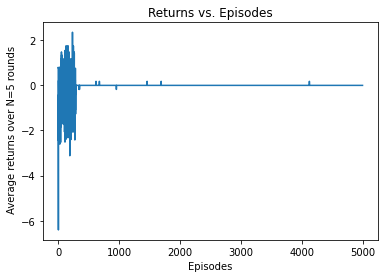

In [6]:
# Plot returns
plot_training_returns(returns, N=5)

## Off Policy Monte Carlo Agent

In [7]:
# Define and train an agent
off_policy_agent = MonteCarloAgent(env)
returns = off_policy_agent.train_off_policy(num_iterations=5000)

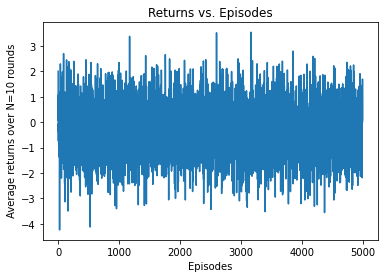

In [8]:
plot_training_returns(returns, N=5)

# TD Agent Class

In [9]:
class TDAgent():
    '''
    Class for agents which can be trained using SARSA and Q-learning
    '''
    
    def __init__(self, env, gamma=0.9, epsilon=0.1, alpha=0.1):
        self.env = env

        # Agent parameters
        self.gamma = gamma
        self.alpha = alpha

        # The base value of epsilon. 
        # TDAgent.epsilon is decayed with iterations while training
        self.epsilon_base = epsilon
        self.epsilon = epsilon
        
        # Action space 
        self.actions = [a for a in range(38)]

        # The state-action value table. Since there is only one state,
        # Q is a table only over the actions
        self.Q = [0.0 for action in self.actions]

        # An epsilon greedy policy over self.Q
        self.policy = [1/len(self.actions) for action in self.actions]

    # Print the Q values
    def printValues(self):
        for action in self.actions:
            print(self.Q[action], end=" ")
        print()

    # Print the policy
    def printPolicy(self):
        for action in self.actions:
            print(self.policy[action], end=" ")
        print()

    # Reset the Q table and other parameters before training
    def reset(self):
        self.Q = [0.0 for action in self.actions]
        self.epsilon = self.epsilon_base
        self.policy = [1/len(self.actions) for action in self.actions]

    # Returns action with the greatest self.Q value. In case of tie, action is chosen
    # randomly from available actions
    def greedy_action(self):
        max_action_value = np.max(self.Q)
        optimal_actions = [action for action in self.actions if self.Q[action] == max_action_value]
        return np.random.choice(optimal_actions)

    # Returns a greedy action with probability 1 - self.epsilon
    def epsilon_greedy_action(self):
        if np.random.random() > self.epsilon:
            return self.greedy_action()
        else:
            return np.random.choice(self.actions)

    # Simulate one episode following an epsilon greedy policy based on self.Q 
    def run(self):
        ret = 0
        done = False
        self.env.reset()
        while not done:
            action = self.epsilon_greedy_action()
            observation, reward, done, info = env.step(action)
            ret = self.gamma*ret + reward
        return ret

    # Calculate and update self.policy as a self.epsilon greedy policy over self.Q
    def calculate_greedy_policy(self):
        for action in self.actions:
            self.policy[action] = self.epsilon / len(self.actions)
        self.policy[np.argmax(self.Q)] += 1 - self.epsilon

    # Make SARSA updates over one simulated episode
    def update_sarsa(self):
        self.env.reset()
        curr_action = self.epsilon_greedy_action()
        done = False
        while not done:
            next_state, reward, done, info = self.env.step(curr_action)
            next_action = self.epsilon_greedy_action()
            self.Q[curr_action] = self.Q[curr_action] + self.alpha * (reward + self.gamma * self.Q[next_action] - self.Q[curr_action])
            curr_action = next_action
    
    # Train using SARSA for num_iters number of episodes
    # Returns a list average returns after each episode of training
    def train_sarsa(self, num_iters=1000, num_runs=10):
        self.reset()
        rets = []
        for iteration in range(1, num_iters+1):
            self.update_sarsa()
            runs = [self.run() for _ in range(num_runs)]
            ret = np.mean(runs)
            rets.append(ret)
            self.epsilon = self.epsilon_base / iteration
        self.calculate_greedy_policy()
        return rets

    # Make Q-learning updates over one simulated episode
    def update_q_learning(self):
        self.env.reset()
        done = False
        while not done:
            action = self.epsilon_greedy_action()
            next_state, reward, done, info = self.env.step(action)
            self.Q[action] = self.Q[action] + self.alpha * (reward + self.gamma * self.Q[self.greedy_action()] - self.Q[action])
    
    # Train using Q-learning for num_iters number of episodes
    # Returns a list average returns after each episode of training
    def train_q_learning(self, num_iters=1000, num_runs=10):
        self.reset()
        rets = []
        for iteration in range(1, num_iters+1):
            self.update_q_learning()
            runs = [self.run() for _ in range(num_runs)]
            ret = np.mean(runs)
            rets.append(ret)
            self.epsilon = self.epsilon_base / iteration
        self.calculate_greedy_policy()
        return rets

## Q learning Agent

In [10]:
# Define and train an agent
q_learning_agent = TDAgent(env)
returns = q_learning_agent.train_q_learning(num_iters=100)

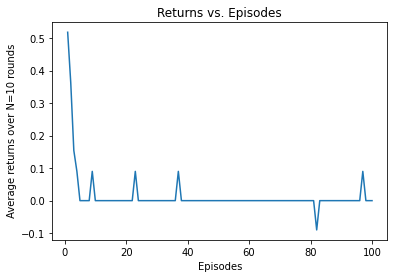

In [11]:
# Plot returns 
plot_training_returns(returns)

## SARSA Agent

In [12]:
# Define and train an agent
sarsa_agent = TDAgent(env)
returns = sarsa_agent.train_sarsa(num_iters=100)

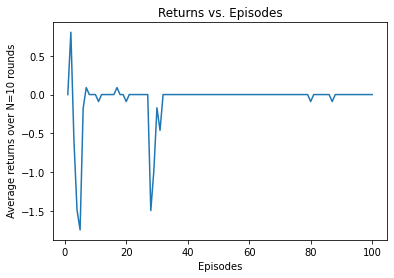

In [13]:
# Plot returns 
plot_training_returns(returns)

# Conclusions

- SARSA and Q learning agents performed better than the Monte Carlo agents (both on and off policy).
- SARSA and Q learning agents were seen to converge in less than 100 episodes each, whereas the Monte Carlo methods took much longer.
- On policy Monte Carlo converged faster than Off Policy Monte Carlo
- Off Policy Monte Carlo ultimately did not seem to converge in the given number of iterations and it is possible that it will take many more iterations to find the optimal policy.
- The other three methods find the optimal policy successfully, which is to not play Roulette at all and exit on the first turn